In [33]:
# import module

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
import collections.abc
collections.Iterable = collections.abc.Iterable
from astrodendro import Dendrogram
from astrodendro import structure
from astrodendro import analysis
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as const

In [34]:
cgs_mp = 9.10938291e-28
cgs_me = 9.10938291e-28 
cgs_xmh =  cgs_mp + cgs_me
yHe = 9.7222222e-2 
mu = (1.e0+4.e0*yHe)*cgs_xmh
pc = 3.0856775814671916*10**18 #cm
solar_mass = 1.989*10**33 #g

In [35]:
def get_data(filename):
  d = {}
  with h5py.File(filename, "r") as data:
    data_list = list(data)
    for ls in data_list:
      d[ls] = data[ls][()]
  return d

In [36]:
d = get_data('C:/Users/kotor/StarGen/datasets/data_ppp/cb2200.h5')

hx = d['space1']
hy = d['space2']
hz = d['space3']

nH = d['nH']
rho = nH * mu
m = rho * (hx*pc)**3 / solar_mass

<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
C:\Users\kotor\AppData\Local\Temp\ipykernel_2120\669607060.py:27: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('mass [$M_\odot$]')


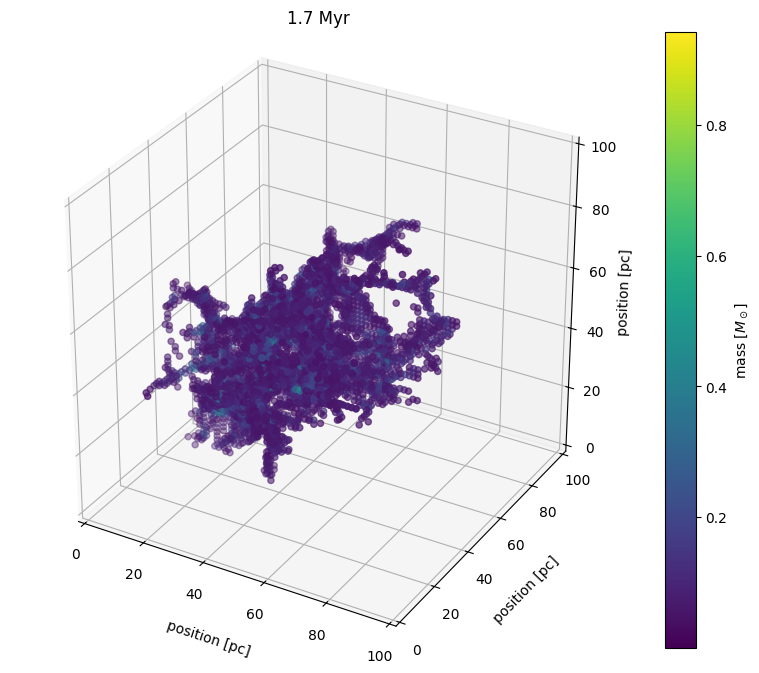

In [37]:
# make 3D map

shape = m.shape
gas_mass = m.reshape(-1)
colormap = plt.get_cmap('viridis')
norm = plt.Normalize(gas_mass.min(), gas_mass.max())

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))

x_coords = np.repeat(np.arange(shape[0]), shape[1]*shape[2]) * hx
y_coords = np.tile(np.repeat(np.arange(shape[1]), shape[2]), shape[0]) * hy
z_coords = np.tile(np.arange(shape[2]), shape[0]*shape[1]) * hz

threshold = 0.05
mask= gas_mass > threshold

x_filtered = x_coords[mask]
y_filtered = y_coords[mask]
z_filtered = z_coords[mask]
gas_mass_filtered = gas_mass[mask]

scatter = ax.scatter(x_filtered, y_filtered, z_filtered, c=gas_mass_filtered, cmap=colormap, norm=norm)  

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('mass [$M_\odot$]')

ax.set_xlim3d(0, 100)
ax.set_ylim3d(0, 100)
ax.set_zlim3d(0, 100)

plt.title("1.7 Myr")

X = ax.set_xlabel('position [pc]', labelpad=10)
Y = ax.set_ylabel('position [pc]', labelpad=10)
Z = ax.set_zlabel('position [pc]', labelpad=4)

In [38]:
# compute dendrogram

dendro = Dendrogram.compute(m, min_value=0.05, min_delta=0.05, min_npix=100)

In [39]:
# make feature list

leaf_indices = [i for i, structure in enumerate(dendro) if structure.is_leaf]
branch_indices = [j for j, structure in enumerate(dendro) if structure.is_branch]

leaf_npix, branch_npix = [], []
for structure_index in leaf_indices:
    structure = dendro[structure_index]
    npix = structure.get_npix() 
    leaf_npix.append(npix)
for structure_index in branch_indices:
    structure = dendro[structure_index]
    npix = structure.get_npix()
    branch_npix.append(npix)    
leaf_sizes = np.array(leaf_npix) * hx * hy * hz
branch_sizes = np.array(branch_npix) * hx * hy * hz

mass_per_leaf, mass_per_branch = [], []
for structure_index in leaf_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    leaf_mass = np.sum(m[indices])
    mass_per_leaf.append(leaf_mass)
for structure_index in branch_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    branch_mass = np.sum(m[indices])
    mass_per_branch.append(branch_mass)
mass_per_leaf = np.array(mass_per_leaf)
mass_per_branch = np.array(mass_per_branch)

x_peak, y_peak, z_peak, peak_value = [], [], [], []
for s in dendro.leaves:
    x_ch, y_ch, z_ch = s.get_peak()[0]
    value = s.get_peak()[1]
    x_peak.append(round(float(x_ch), 6) * hx)
    y_peak.append(round(float(y_ch), 6) * hy)
    z_peak.append(round(float(z_ch), 6) * hz)
    peak_value.append(round(float(value), 6))

leaf_radius = np.cbrt(3 * (np.array(leaf_sizes)) / (4 * np.pi)) 
branch_radius = np.cbrt(3 * (np.array(branch_sizes)) / (4 * np.pi))

leaf_feature = pd.DataFrame({
    'id':leaf_indices, 
    'leaf_size [pc^2]':leaf_sizes, 
    'leaf_mass [solar mass]':mass_per_leaf,
    'x_peak':x_peak, 
    'y_peak':y_peak,
    'z_peak':z_peak, 
    'peak_value [solar mass]':peak_value,
    'leaf_radius [pc]':leaf_radius,
    'fwhm [km/s]':'',
    'virial_parameter':''})
branch_feature = pd.DataFrame({
    'id':branch_indices, 
    'branch_size [pc^2]':branch_sizes, 
    'branch_mass [solar mass]':mass_per_branch,
    'branch_radius [pc]':branch_radius,
    'fwhm [km/s]':'',
    'virial_parameter':''})

leaf_size_ave = np.sum(leaf_sizes) / len(leaf_indices)
branch_size_ave = np.sum(branch_sizes) / len(branch_indices)
leaf_mass_ave = np.sum(mass_per_leaf) / len(leaf_indices)
branch_mass_ave = np.sum(mass_per_branch) / len(branch_indices)

display(leaf_feature)
print('leaf size average:', leaf_size_ave)
print('leaf mass average:', leaf_mass_ave)
#print('leaf virial parameter average:', leaf_vir_ave)
display(branch_feature)
print('branch size average:', branch_size_ave)
print('branch mass average:', branch_mass_ave)
#print('branch virial parameter average:', branch_vir_ave)


,id,leaf_size [pc^2],leaf_mass [solar mass],x_peak,y_peak,z_peak,peak_value [solar mass],leaf_radius [pc],fwhm [km/s],virial_parameter
0,2,5153.972932,299.800993,19.379883,45.681152,22.148438,0.585256,10.715633,,
1,7,294.436951,23.093342,34.606934,41.528320,29.069824,0.942892,4.127001,,
2,8,1087.559908,84.737299,27.685547,47.065430,45.681152,0.867156,6.379523,,
3,10,668.451456,51.050520,31.838379,52.602539,44.296875,0.661669,5.424093,,
4,11,315.657632,11.920940,34.606934,80.288086,51.218262,0.236397,4.223857,,
5,12,793.122958,51.280291,45.681152,47.065430,44.296875,0.837759,5.742275,,
6,13,336.878313,11.963128,51.218262,80.288086,65.061035,0.259093,4.316464,,
7,14,302.394706,14.494126,65.061035,60.908203,40.144043,0.340473,4.163851,,


leaf size average: 1119.0593570518104
leaf mass average: 68.54257964732822


,id,branch_size [pc^2],branch_mass [solar mass],branch_radius [pc],fwhm [km/s],virial_parameter
0,0,10042.687350,452.147904,13.384036,,
1,1,11464.472986,490.962677,13.987985,,
2,3,7583.740923,386.442042,12.187977,,
3,4,2893.970391,190.661485,8.840330,,
4,5,400.540357,29.910163,4.572839,,
5,6,660.493701,53.404594,5.402482,,
6,9,334.225728,26.186999,4.305105,,


branch size average: 4768.590204999782
branch mass average: 232.81655194251394


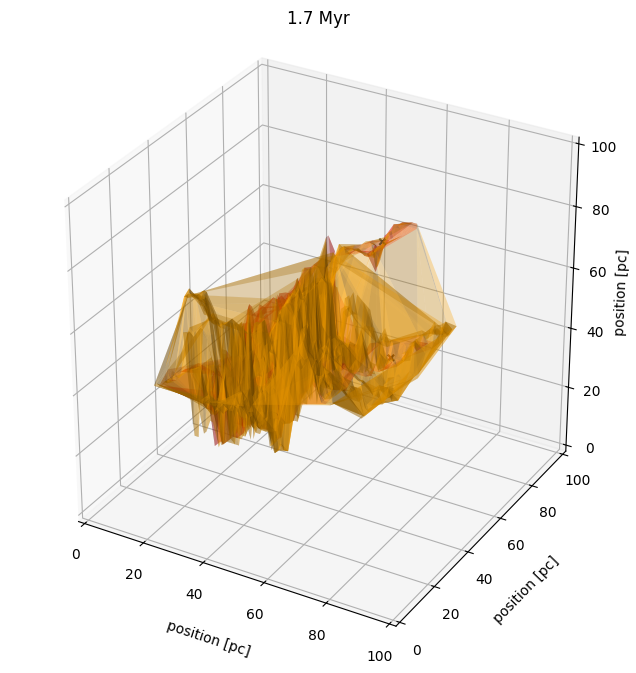

In [40]:
# plot the contour

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))

for i, structure_index in enumerate(leaf_indices):
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    ax.plot_trisurf(indices[0] * hx, indices[1] * hy, indices[2] * hz, color='red', alpha=0.3)    
for j, structure_index in enumerate(branch_indices):
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    ax.plot_trisurf(indices[0] * hx, indices[1] * hy, indices[2] * hz, color='orange', alpha=0.3)

ax.scatter(leaf_feature['x_peak'], leaf_feature['y_peak'], leaf_feature['z_peak'], marker='x', color='black')

ax.set_xlim3d(0, 100)
ax.set_ylim3d(0, 100)
ax.set_zlim3d(0, 100)

plt.title("1.7 Myr")
X = ax.set_xlabel('position [pc]', labelpad=10)
Y = ax.set_ylabel('position [pc]', labelpad=10)
Z = ax.set_zlabel('position [pc]', labelpad=3)